# EC 424 Project: Predicting Price of Avocados
### How well can we predict the average price of a single Hass avocado?

In [42]:
# Load packages
library(pacman)
p_load(tidyverse, caret, caretEnsemble, magrittr, janitor, ggplot2, rpart, rpart.plot)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


caretEnsemble installed



# Data
Our data concerns the average prices of Hass avocados in the United States from 2013 to 2018, aggregated across grocery, mass, club, drug, dollar, and military channels. The data comes from [this](https://www.kaggle.com/neuromusic/avocado-prices) Kaggle page. In May of 2018, Kaggle user Justin Kiggins downloaded this data from the [Hass Avocado Board website](https://hassavocadoboard.com/) and compiled it into a csv. The variables included in this file, with cleaned names, are as follows:

The outcome:

`average_price`: the average per unit (i.e. per avocado) price of Hass avocados, even when multiple avocados are sold together in bags

The predictors:

`week_of_year`: an integer from 0 to 51, where 0 represents the final week of December and 51 represents the first week of January (this variable is missing a name in the original csv so it gets imported with the name `X1` and we immediately rename it)

`date`: the date of the observation

`total_volume`: the number of avocados sold

`x4046`: the number of avocados sold with product lookup code (PLU) 4046

`x4225`: the number of avocados sold with PLU 4225

`x4770`: the number of avocados sold with PLU 4770

`total_bags`: the number of bags of avocados sold

`small_bags`: the number of small bags of avocados sold

`large_bags`: the number of large bags of avocados sold

`x_large_bags`: the number of extra large bags of avocados sold

`type`: a categorical variable with two levels, conventional and organic

`year`: the year of the observation

`region`: a categorical variable with 54 levels giving various regions of the United States where avocados were sold

We also create an `id` column where each observation gets a unique ID number. Later, we use this variable to split the data into train and test sets.

In [2]:
# Read the data from the Kaggle page
avocado = read_csv("../input/avocado-prices/avocado.csv") %>%
    rename(week_of_year = X1) %>%
    clean_names()
# Add a variable corresponding to observation number
avocado = avocado %>% mutate(id = rownames(avocado))

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  X1 = col_double(),
  Date = col_date(format = ""),
  AveragePrice = col_double(),
  `Total Volume` = col_double(),
  `4046` = col_double(),
  `4225` = col_double(),
  `4770` = col_double(),
  `Total Bags` = col_double(),
  `Small Bags` = col_double(),
  `Large Bags` = col_double(),
  `XLarge Bags` = col_double(),
  type = col_character(),
  year = col_double(),
  region = col_character()
)



In [3]:
# Inspect the data, get dimensions
head(avocado)
dim(avocado)

week_of_year,date,average_price,total_volume,x4046,x4225,x4770,total_bags,small_bags,large_bags,x_large_bags,type,year,region,id
<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0,conventional,2015,Albany,1
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0,conventional,2015,Albany,2
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0,conventional,2015,Albany,3
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0,conventional,2015,Albany,4
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0,conventional,2015,Albany,5
5,2015-11-22,1.26,55979.78,1184.27,48067.99,43.61,6683.91,6556.47,127.44,0,conventional,2015,Albany,6


[1] 18249    15

### Visualization

Before we attempt to make predictions, we summarize our data with some plots. Our outcome variable, `average_price`, is distributed approximately normally with a slight right skew. Unsurprisingly, the prices of conventional and organic avocados have slightly different distributions, with organic avocados being slightly more expensive. Generally, a single avocado costs between 1 and 2 dollars, and both the mean and median of the `average_price` outcome are around \$1.40. Our observations are uniformly distributed across time, as shown by the histogram of `date`.

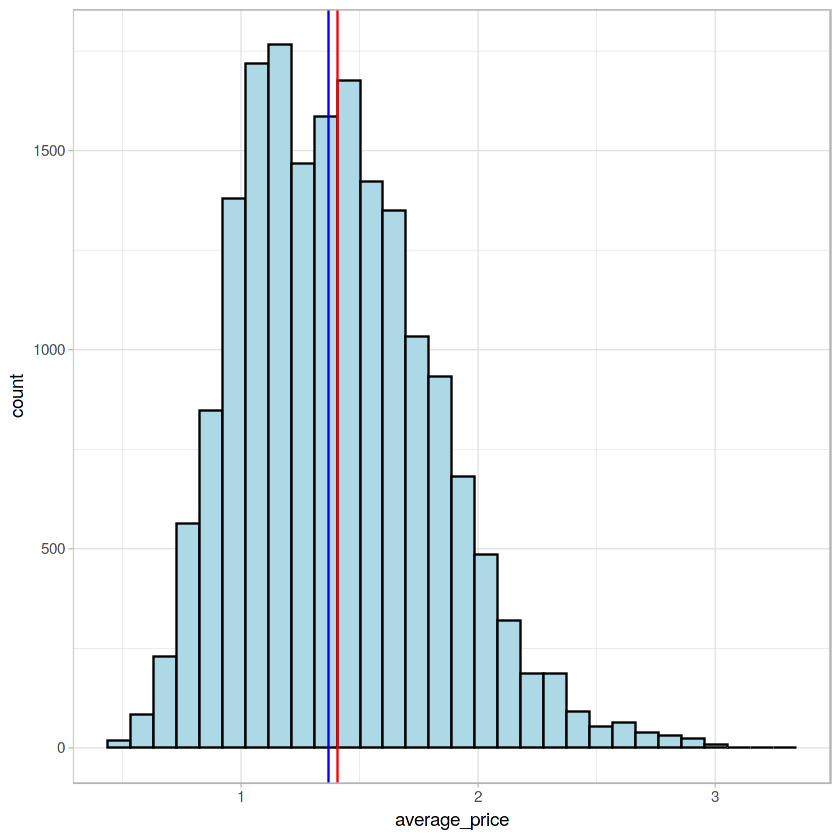

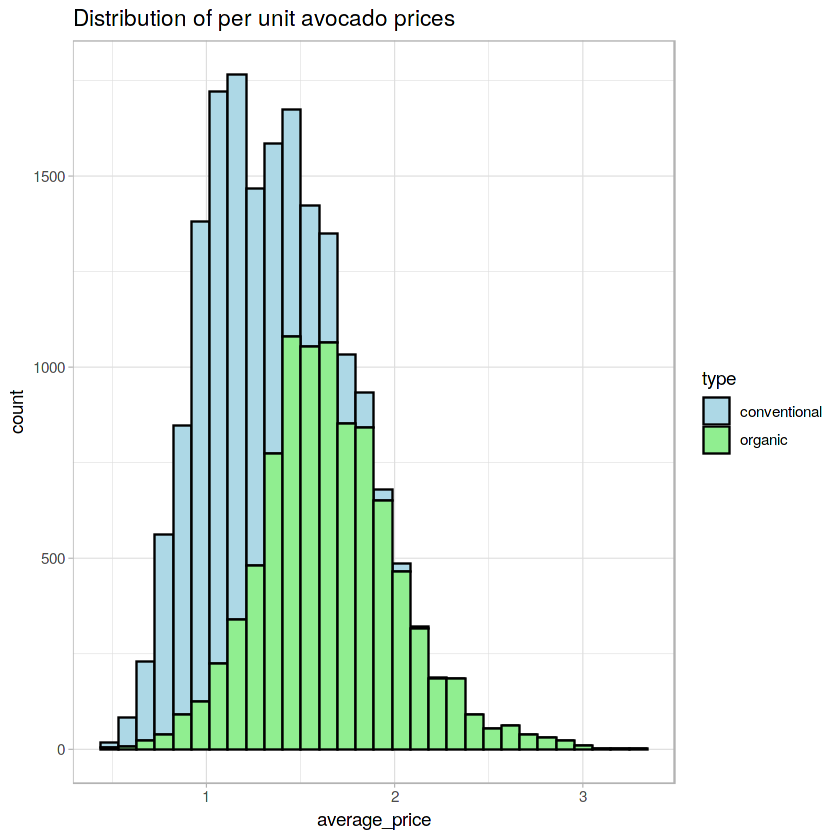

In [4]:
# Histogram of outcome variable average_price
ggplot(avocado, aes(x = average_price)) + geom_histogram(bins = 30, fill = "lightblue", col = "black") +
    geom_vline(aes(xintercept = mean(average_price)), colour = "red") +
    geom_vline(aes(xintercept = median(average_price)), colour = "blue") +
    theme_light()

# Histogram of average_price for conventional and organic avocados
ggplot(avocado, aes(x = average_price, fill = type)) +
    geom_histogram(bins = 30, col = "black") +
    scale_fill_manual(values = c("lightblue", "lightgreen")) +
    ggtitle("Distribution of per unit avocado prices") + theme_light()

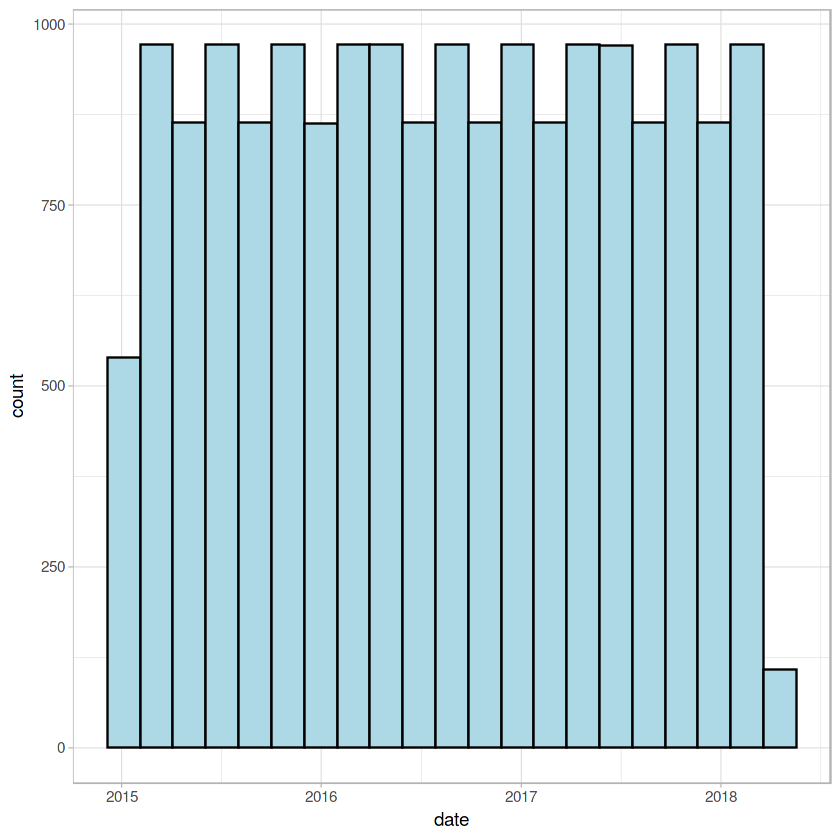

In [5]:
# Histogram of date variable
ggplot(avocado, aes(x = date)) +
    geom_histogram(binwidth = 60, fill = "lightblue", col = "black") +
    theme_light()

The variables describing volumes and bags of avocados sold are extremely right-skewed - that is, there are a small number of observations having very high values - so we view histograms of these variables on a log scale.

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 242 rows containing non-finite values (stat_bin).”


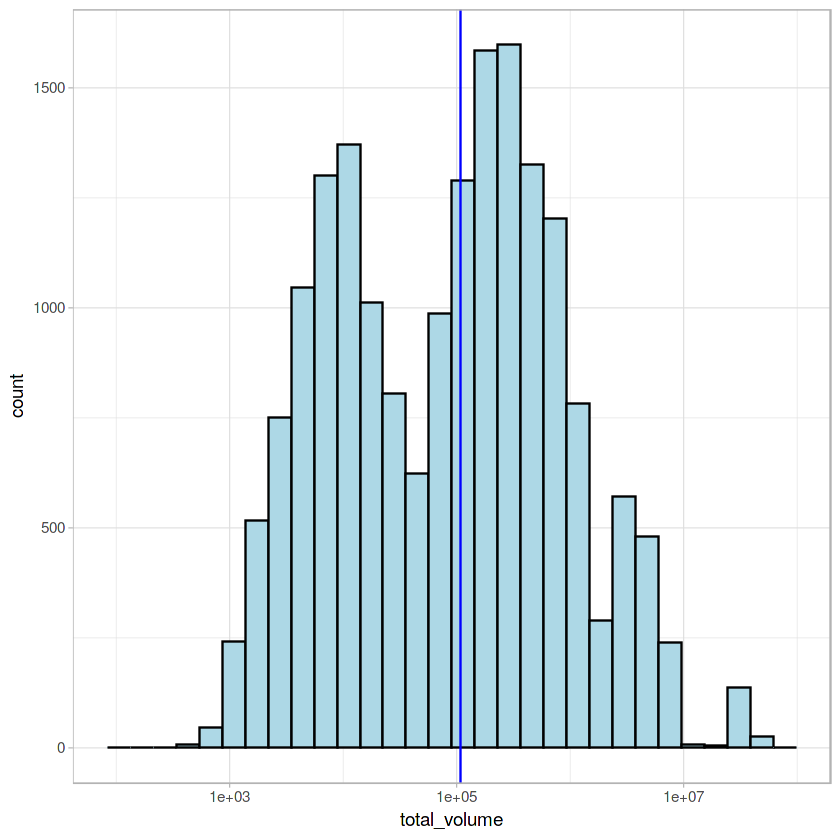

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 61 rows containing non-finite values (stat_bin).”


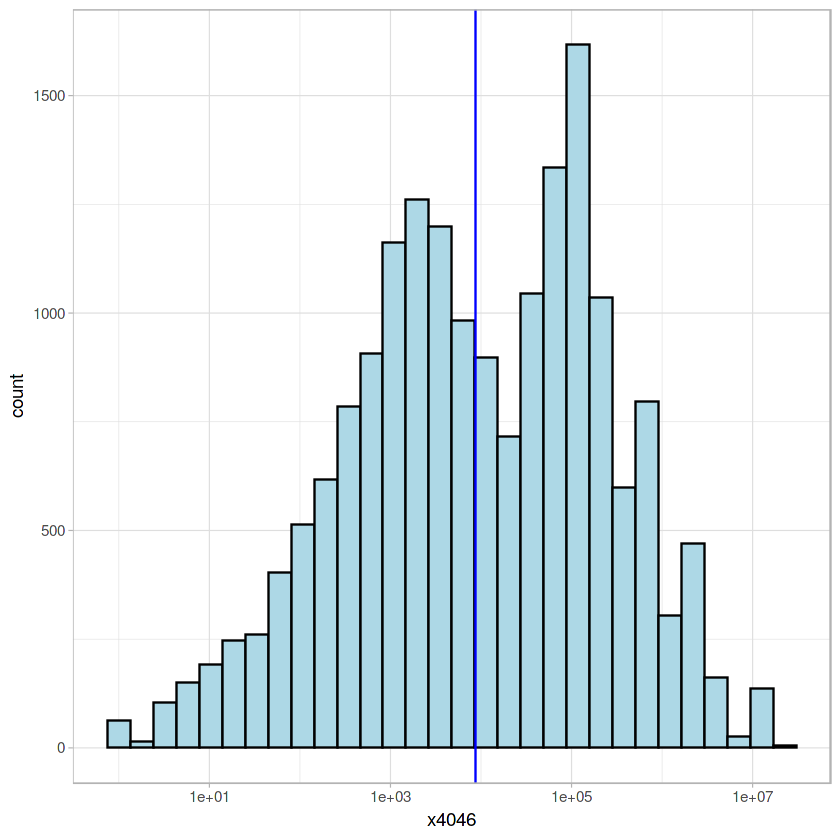

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 5497 rows containing non-finite values (stat_bin).”


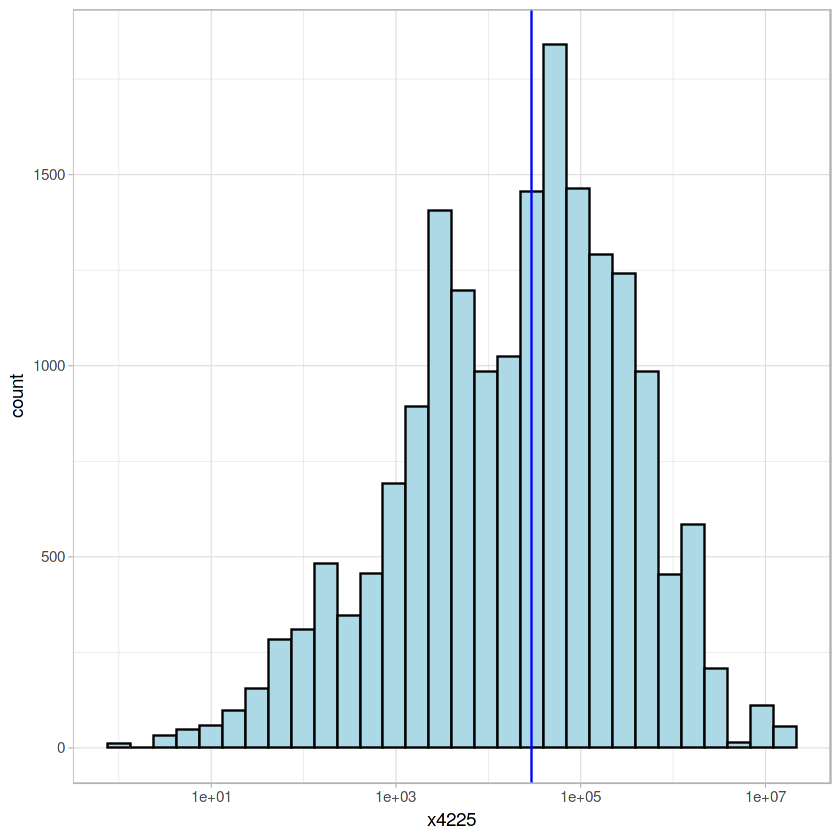

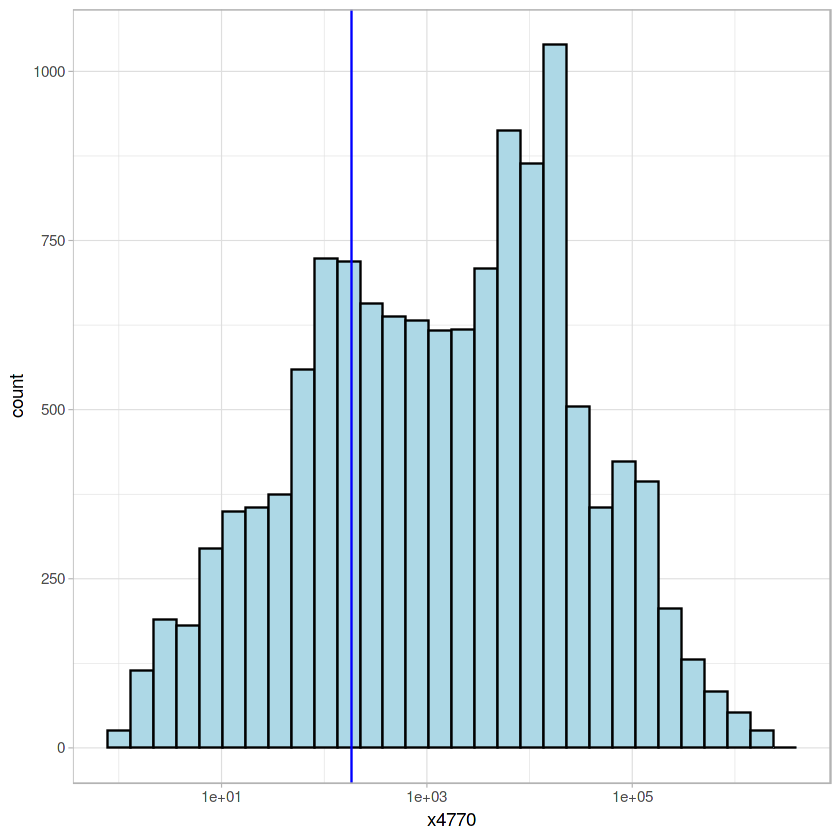

In [6]:
# Histograms for total volume, and volumes for PLU 4046, PLU 4225, PLU 4770
ggplot(avocado, aes(x = total_volume)) +
    geom_histogram(bins = 30, fill = "lightblue", col = "black") +
    scale_x_log10() +
    geom_vline(aes(xintercept = median(total_volume)), colour = "blue") +
    theme_light()

ggplot(avocado, aes(x = x4046)) +
    geom_histogram(bins = 30, fill = "lightblue", col = "black") +
    scale_x_log10() +
    geom_vline(aes(xintercept = median(x4046)), colour = "blue") +
    theme_light()

ggplot(avocado, aes(x = x4225)) +
    geom_histogram(bins = 30, fill = "lightblue", col = "black") +
    scale_x_log10() +
    geom_vline(aes(xintercept = median(x4225)), colour = "blue") +
    theme_light()

ggplot(avocado, aes(x = x4770)) +
    geom_histogram(bins = 30, fill = "lightblue", col = "black") +
    scale_x_log10() +
    geom_vline(aes(xintercept = median(x4770)), colour = "blue") +
    theme_light()

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 15 rows containing non-finite values (stat_bin).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 159 rows containing non-finite values (stat_bin).”


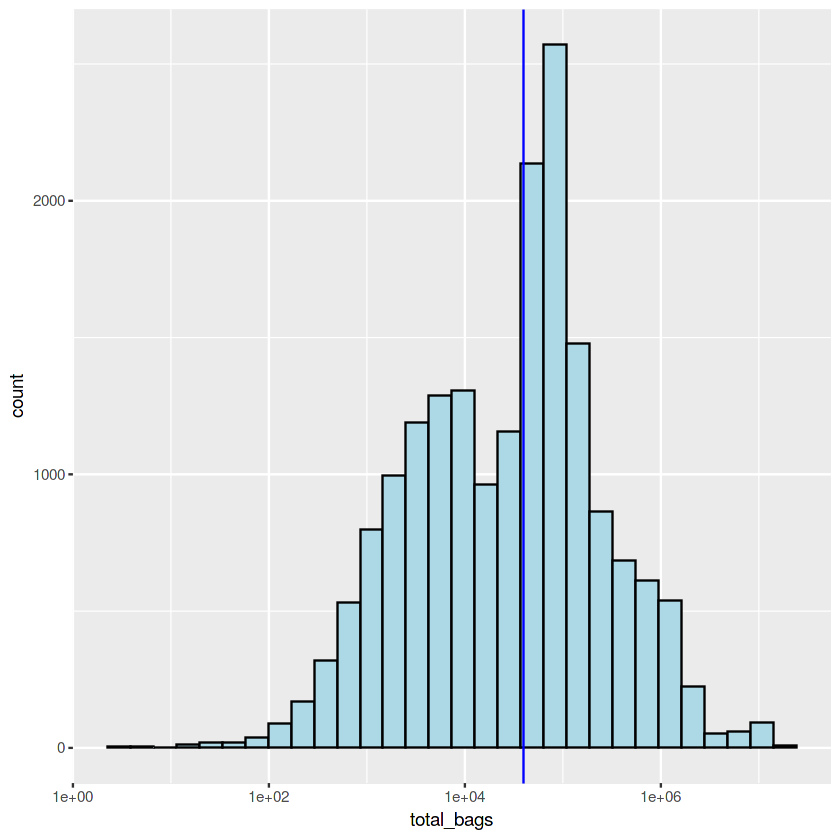

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 2370 rows containing non-finite values (stat_bin).”


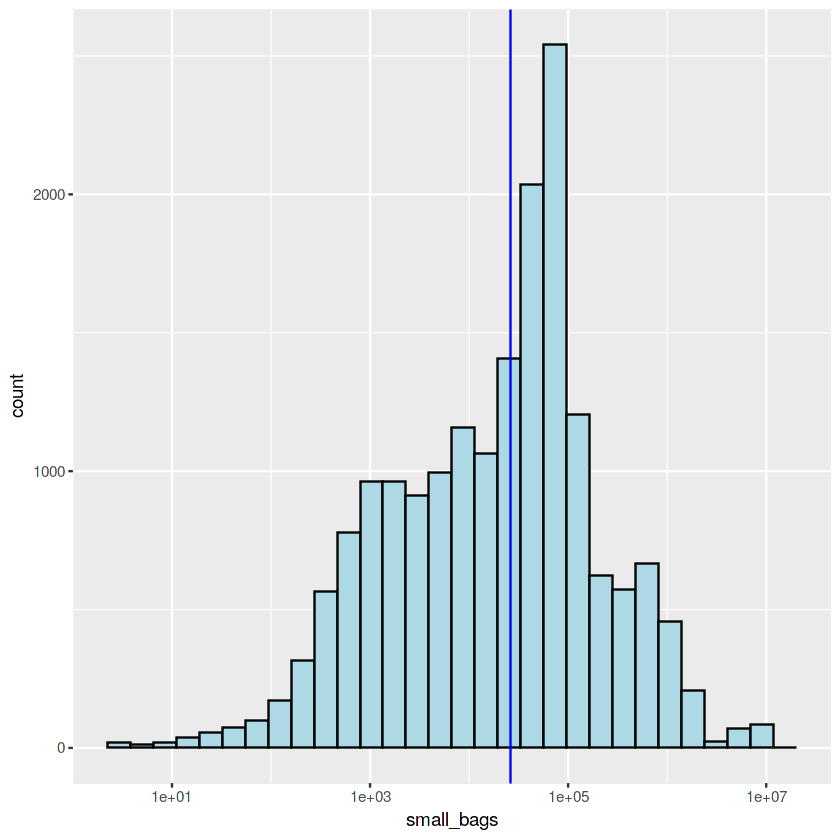

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 12048 rows containing non-finite values (stat_bin).”


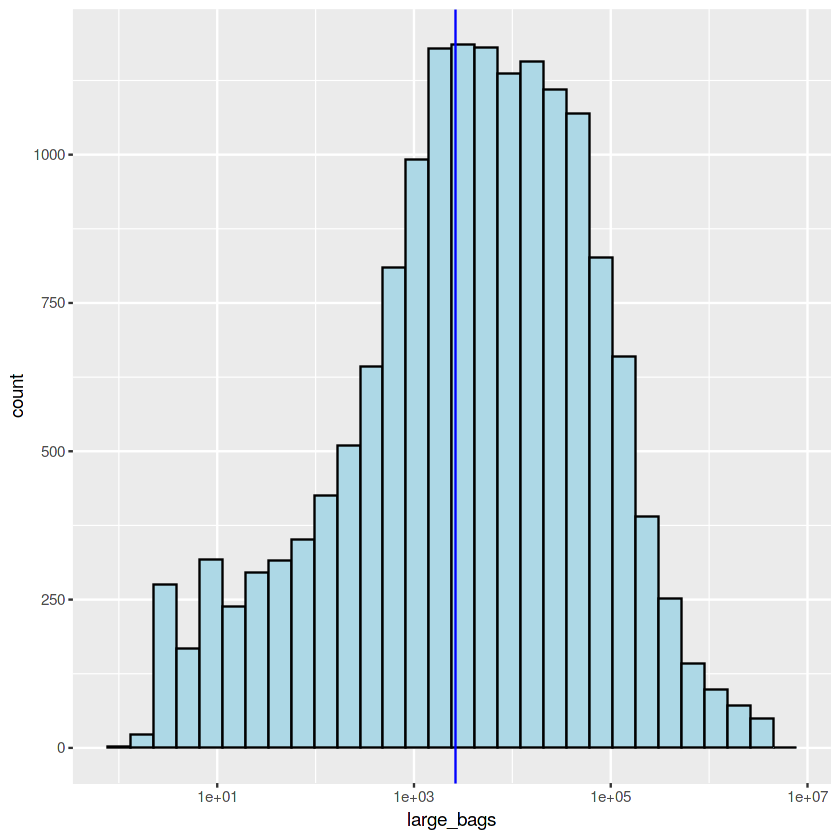

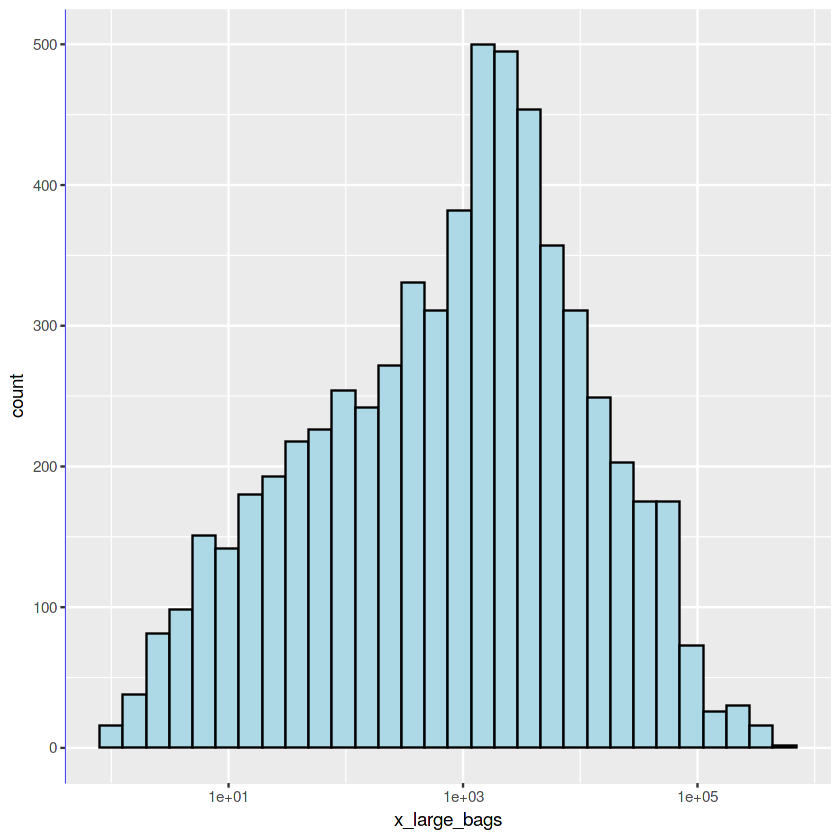

In [7]:
# Histograms for total bags, and small, large, xlarge bags
ggplot(avocado, aes(x = total_bags)) +
    geom_histogram(bins = 30, fill = "lightblue", col = "black") +
    scale_x_log10() +
    geom_vline(aes(xintercept = median(total_bags)), colour = "blue")

ggplot(avocado, aes(x = small_bags)) +
    geom_histogram(bins = 30, fill = "lightblue", col = "black") +
    scale_x_log10() +
    geom_vline(aes(xintercept = median(small_bags)), colour = "blue")

ggplot(avocado, aes(x = large_bags)) +
    geom_histogram(bins = 30, fill = "lightblue", col = "black") +
    scale_x_log10() +
    geom_vline(aes(xintercept = median(large_bags)), colour = "blue")

ggplot(avocado, aes(x = x_large_bags)) +
    geom_histogram(bins = 30, fill = "lightblue", col = "black") +
    scale_x_log10() +
    geom_vline(aes(xintercept = median(x_large_bags)), colour = "blue")

Also, our observations are uniformly distributed across the regions studied, and half the observations are for organic avocados while half are for conventional.

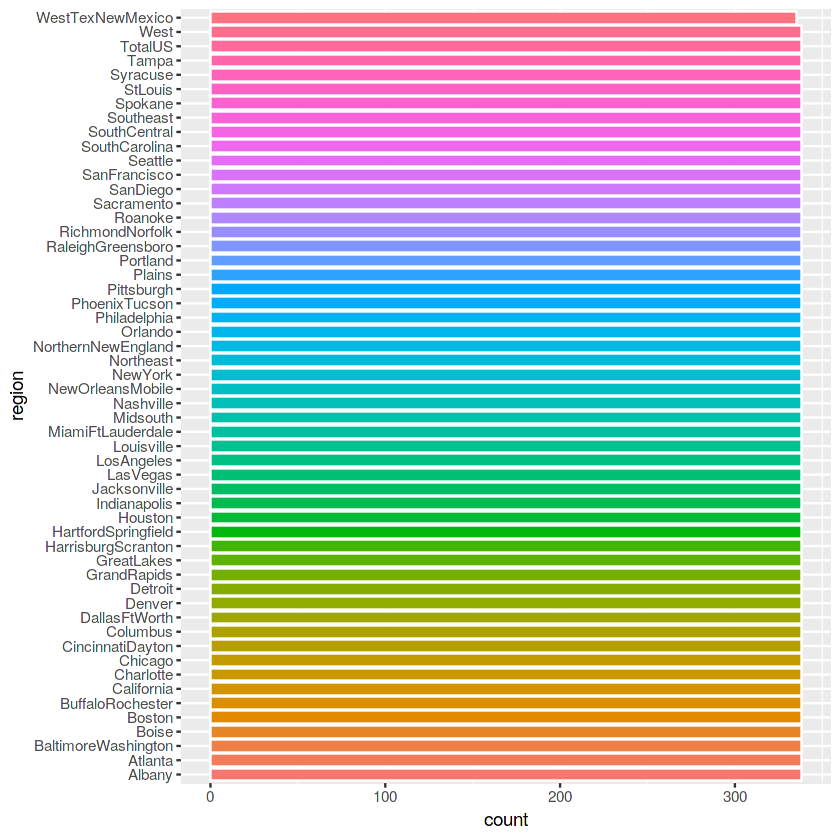

In [8]:
# Bar chart of regions
ggplot(avocado, aes(x = region, fill = region)) +
    geom_bar(col = "white") +
    coord_flip() +
    theme(legend.position = "none") 

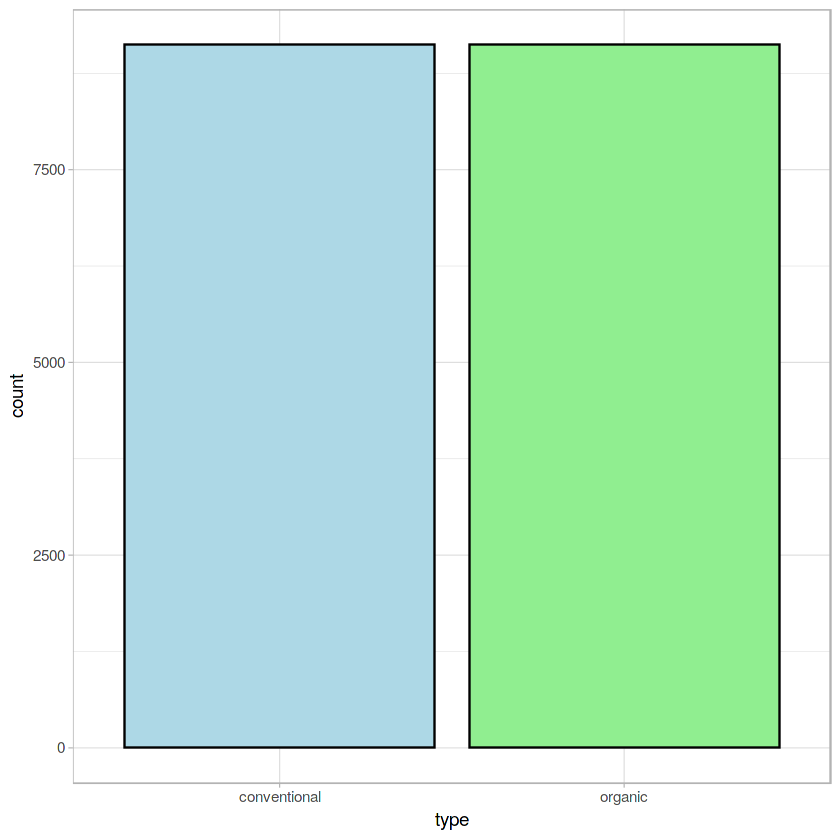

In [9]:
# Bar chart of type, conventional or organic
ggplot(avocado, aes(x = type, fill = type)) +
    geom_bar(fill = c("lightblue", "lightgreen"), col = "black") +
    theme_light()

## Data Cleaning
As mentioned above, the first column of the `avocado` dataframe doesn't have a name so it gets imported with the name `X1`. Since it represents the week out of the year, we rename this column to `week_of_year`. Then we create a column for row ID's, called `id`, in the dataframe for the purpose of keeping track of the training and testing data. We also create a `season` column in `avocado` using the existing `date` column, as we figured season could be important since produce grows seasonally.

We randomly select 20% of the rows to hold out for testing (first setting a seed to make sure we get the same test set each the time code is run), and store these row ID's in a vector called `test_rows`. There are no missing values in our dataset. If there were missing values we would use the medianImpute method in preProcess for numerical values, and we would write a mode imputation function for categorical variables. 

Several of our prediction methods (including Elasticnet, KNN, and SVM) require categorical variables to be converted to dummies, and the data to be centered and scaled. We create a new version of the `avocado` dataframe, called `avocado_cs` (for avocado centered scaled), with the data pre-processed this way. We retain the `avocado` dataframe because other methods (such as random forests) want categorical variables to remain as categories instead of dummies, and don't care whether the data is centered and scaled.

For both `avocado` and `avocado_cs`, we split into training and testing sets using the `test_rows` vector created above. We remove the outcome variable from the testing sets.


In [10]:
# Set a seed and then randomly select 20% of data to be used for testing
set.seed(46848)
test_rows = sample(avocado$id, nrow(avocado)*0.2, replace = F) %>% as.numeric()

In [11]:
# There are no missing values in the avocado dataframe
colSums(is.na(avocado))

week_of_year          date average_price  total_volume         x4046 
            0             0             0             0             0 
        x4225         x4770    total_bags    small_bags    large_bags 
            0             0             0             0             0 
 x_large_bags          type          year        region            id 
            0             0             0             0             0

In [12]:
# Create a variable equal to season 
months <- strptime(avocado$date, format='%Y-%m-%d')$mon + 1
indx <- setNames(rep(c('winter', 'spring', 'summer','fall'),each=3), c(12,1:11))
avocado$season = unname(indx[as.character(months)])

In [13]:
# Create dummies, and center and scale the data
avocado_cs = dummyVars(average_price ~ .,
                       data = avocado %>% select(-id),
                       fullRank = T) %>% predict(newdata = avocado) %>% as.data.frame()

# Manually center and scale date
avocado_cs$date = (avocado_cs$date - mean(avocado_cs$date))/sd(avocado_cs$date)

avocado_cs = preProcess(
    x = avocado %>% select(-c("average_price", "id")),
    method = c("center", "scale")
) %>% predict(newdata = avocado_cs) %>% as.data.frame()

# Add back the average price and id columns to the now centered and scaled data
avocado_cs = avocado_cs %>% mutate(average_price = avocado$average_price, id = avocado$id)

In [14]:
# Inspect the pre-processed dataframe
head(avocado_cs)
dim(avocado_cs)

,week_of_year,date,total_volume,x4046,x4225,x4770,total_bags,small_bags,large_bags,x_large_bags,⋯,regionSyracuse,regionTampa,regionTotalUS,regionWest,regionWestTexNewMexico,seasonspring,seasonsummer,seasonwinter,average_price,id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,-1.565284,-0.6763413,-0.2277102,-0.2308096,-0.1998967,-0.2120855,-0.2341639,-0.2326401,-0.2223459,-0.1755748,⋯,0,0,0,0,0,0,0,1,1.33,1
2,-1.500689,-0.6968383,-0.2304203,-0.2310962,-0.2080488,-0.2119909,-0.2333439,-0.2315620,-0.2223285,-0.1755748,⋯,0,0,0,0,0,0,0,1,1.35,2
3,-1.436094,-0.7173353,-0.2120788,-0.2310010,-0.1544737,-0.2113193,-0.2347231,-0.2333925,-0.2223054,-0.1755748,⋯,0,0,0,0,0,0,0,1,0.93,3
4,-1.371499,-0.7378323,-0.2234376,-0.2307343,-0.1853454,-0.2118583,-0.2370898,-0.2365617,-0.2221799,-0.1755748,⋯,0,0,0,0,0,0,0,1,1.08,4
5,-1.306904,-0.7583293,-0.2315315,-0.2308850,-0.2087135,-0.2118285,-0.2367118,-0.2361478,-0.2219178,-0.1755748,⋯,0,0,0,0,0,0,0,0,1.28,5
6,-1.242308,-0.7788263,-0.2301010,-0.2306930,-0.2052009,-0.2121279,-0.2362049,-0.2353836,-0.2222058,-0.1755748,⋯,0,0,0,0,0,0,0,0,1.26,6


[1] 18249    70

In [15]:
# Now we split all avocado dataframes into training and testing sets

# for non-dummies, non-centered, non-scaled
train = avocado %>% filter(!id %in% test_rows)
test = avocado %>% filter(id %in% test_rows) %>% select(-average_price)


# for dummies, centered, scaled
train_cs = avocado_cs %>% filter(!id %in% test_rows)
test_cs = avocado_cs %>% filter(id %in% test_rows) %>% select(-average_price)


In [16]:
# Inspect our training and testing sets

head(train)
dim(train)

head(test)
dim(test)

head(train_cs)
dim(train_cs)

head(test_cs)
dim(test_cs)

week_of_year,date,average_price,total_volume,x4046,x4225,x4770,total_bags,small_bags,large_bags,x_large_bags,type,year,region,id,season
<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0,conventional,2015,Albany,1,winter
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0,conventional,2015,Albany,2,winter
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0,conventional,2015,Albany,3,winter
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0,conventional,2015,Albany,5,fall
5,2015-11-22,1.26,55979.78,1184.27,48067.99,43.61,6683.91,6556.47,127.44,0,conventional,2015,Albany,6,fall
6,2015-11-15,0.99,83453.76,1368.92,73672.72,93.26,8318.86,8196.81,122.05,0,conventional,2015,Albany,7,fall


[1] 14600    16

week_of_year,date,total_volume,x4046,x4225,x4770,total_bags,small_bags,large_bags,x_large_bags,type,year,region,id,season
<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>
3,2015-12-06,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0,conventional,2015,Albany,4,winter
11,2015-10-11,64489.17,1582.03,52677.92,105.32,10123.90,9866.27,257.63,0,conventional,2015,Albany,12,fall
12,2015-10-04,61007.10,2268.32,49880.67,101.36,8756.75,8379.98,376.77,0,conventional,2015,Albany,13,fall
14,2015-09-20,69759.01,1028.03,59313.12,150.50,9267.36,8489.10,778.26,0,conventional,2015,Albany,15,fall
16,2015-09-06,99172.96,879.45,90062.62,240.79,7990.10,7762.87,227.23,0,conventional,2015,Albany,17,fall
26,2015-06-28,89534.81,664.23,57545.79,4662.71,26662.08,26311.76,350.32,0,conventional,2015,Albany,27,summer


[1] 3649   15

,week_of_year,date,total_volume,x4046,x4225,x4770,total_bags,small_bags,large_bags,x_large_bags,⋯,regionSyracuse,regionTampa,regionTotalUS,regionWest,regionWestTexNewMexico,seasonspring,seasonsummer,seasonwinter,average_price,id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,-1.565284,-0.6763413,-0.2277102,-0.2308096,-0.1998967,-0.2120855,-0.2341639,-0.2326401,-0.2223459,-0.1755748,⋯,0,0,0,0,0,0,0,1,1.33,1
2,-1.500689,-0.6968383,-0.2304203,-0.2310962,-0.2080488,-0.2119909,-0.2333439,-0.2315620,-0.2223285,-0.1755748,⋯,0,0,0,0,0,0,0,1,1.35,2
3,-1.436094,-0.7173353,-0.2120788,-0.2310010,-0.1544737,-0.2113193,-0.2347231,-0.2333925,-0.2223054,-0.1755748,⋯,0,0,0,0,0,0,0,1,0.93,3
4,-1.306904,-0.7583293,-0.2315315,-0.2308850,-0.2087135,-0.2118285,-0.2367118,-0.2361478,-0.2219178,-0.1755748,⋯,0,0,0,0,0,0,0,0,1.28,5
5,-1.242308,-0.7788263,-0.2301010,-0.2306930,-0.2052009,-0.2121279,-0.2362049,-0.2353836,-0.2222058,-0.1755748,⋯,0,0,0,0,0,0,0,0,1.26,6
6,-1.177713,-0.7993233,-0.2221457,-0.2305471,-0.1839366,-0.2116659,-0.2345471,-0.2331853,-0.2222279,-0.1755748,⋯,0,0,0,0,0,0,0,0,0.99,7


[1] 14600    70

,week_of_year,date,total_volume,x4046,x4225,x4770,total_bags,small_bags,large_bags,x_large_bags,⋯,regionStLouis,regionSyracuse,regionTampa,regionTotalUS,regionWest,regionWestTexNewMexico,seasonspring,seasonsummer,seasonwinter,id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,-1.3714986,-0.7378323,-0.2234376,-0.2307343,-0.1853454,-0.2118583,-0.2370898,-0.2365617,-0.2221799,-0.1755748,⋯,0,0,0,0,0,0,0,0,1,4
2,-0.8547377,-0.9018083,-0.2276370,-0.2303786,-0.2013724,-0.2115537,-0.2327169,-0.2309480,-0.2216721,-0.1755748,⋯,0,0,0,0,0,0,0,0,0,12
3,-0.7901425,-0.9223053,-0.2286453,-0.2298361,-0.2036955,-0.2115905,-0.2341031,-0.2329398,-0.2211838,-0.1755748,⋯,0,0,0,0,0,0,0,0,0,13
4,-0.6609523,-0.9632993,-0.2261111,-0.2308165,-0.1958620,-0.2111332,-0.2335854,-0.2327936,-0.2195381,-0.1755748,⋯,0,0,0,0,0,0,0,0,0,15
5,-0.5317620,-1.0042933,-0.2175941,-0.2309340,-0.1703251,-0.2102930,-0.2348805,-0.2337669,-0.2217968,-0.1755748,⋯,0,0,0,0,0,0,0,0,0,17
6,0.1141892,-1.2092632,-0.2203849,-0.2311041,-0.1973298,-0.1691452,-0.2159480,-0.2089084,-0.2212922,-0.1755748,⋯,0,0,0,0,0,0,0,1,0,27


[1] 3649   69

# Training and Prediction

Now we train four different models - Elasticnet, KNN, Random Forest, and SVM - on the training data sets, calling various methods in the `train` function from `caret`. We use each model to predict avocado prices on the testing data, and create a dataframe of our results including the `id` column, the actual average price (which we didn't train on, but we know because the test data was created by holding out 20% of the full dataset), and our predictions of the average price. We call these dataframes, respectively, `net_df`, `knn_df`, `forest_df`, and `svm_df`. In the next section, we will use these results dataframes to evaluate how well we did at predicing average prices.

### Model 1: Elasticnet

In [17]:
# Train an elasticnet model on the train_cs set (centered and scaled with dummies)

# Set range of lambdas, the size of the penalty
lambdas = 10 ^ seq(from = 1, to = -3, length = 1e2)
# Set range of alphas, the relative weight on ridge and lasso penalties
alphas = seq(from = 0, to = 1, by = 0.05)

# Train an elasticnet model with 5-fold cross validation
avo_net = train(
    # The model: predict average price based on everything else
    average_price ~.,
    # The data: our dummied/centered/scaled training set, without the id column
    data = train_cs %>% select(-id),
    # Use an Elasticnet model
    method = "glmnet",
    # Evaluate performance with 5-fold cross validation
    trControl = trainControl("cv", number = 5),
    # The tuning parameters: the alphas and lambdas defined above
    tuneGrid = expand.grid(alpha = alphas, lambda = lambdas)
)


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


In [18]:
# The alpha and lambda chosen by our trained Elasticnet model
avo_net$bestTune

,alpha,lambda
,<dbl>,<dbl>
101,0.05,0.001


In [19]:
# Make predictions on test set
net_pred = predict(
    avo_net,
    newdata = test_cs
)

# The results
net_df = data.frame(
    id = test_cs %>% select(id),
    average_price = avocado %>% filter(id %in% test_rows) %>% select(average_price),
    pred = net_pred
)

In [20]:
# Inspect results
head(net_df)

,id,average_price,pred
,<chr>,<dbl>,<dbl>
1,4,1.08,1.120666
2,12,1.28,1.340869
3,13,1.31,1.340075
4,15,1.33,1.338310
5,17,1.11,1.336469
6,27,1.37,1.260994


### Model 2: K Nearest Neighbors (KNN)

For our KNN model, to avoid the curse of dimensionality and unreasonably long run times, we select only a subset of the predictors. We first tried to choose the predictors for KNN using forward stepwise selection, however the resulting RMSE of the predictions was around 0.5, double our "worst" performing model. Instead of choosing the variables with subset selection we used our own "intuition" to pick a subset of variables that seemed reasonable based on our exploratory data analysis. 

In [21]:
# We considered selecting knn predictors using stepwise selection, but this didn't work well
# We leave the code here, commented out, in case we want to revive it.

#knn_vars = train(
    # The model: predict average price based on week, date, total volume, and organic indicator
#    average_price ~ .,
    # The data: dummied/centered/scaled training data without id column
#    data = train_cs %>% select(-id),
    # Use a KNN model
#    method = "leapForward",
    # Evaluate performance with 5-fold cross validation
#    trControl = trainControl(method = "cv", number = 5),
    # Tuning parameter: the number of nearest neighbors, k
#    tuneGrid = expand.grid(nvmax = seq(1, 5, by = 1))
#)

#optimal_var_num = knn_vars$bestTune$nvmax
#what_cols = knn_vars$finalModel$vorder[1:optimal_var_num]
#what_vars = knn_vars$finalModel$xnames[what_cols]
#x_dat = select(train_cs, one_of(what_vars))

#head(x_dat)

In [22]:
# Train a knn model on the train_cs set (centered and scaled with dummies)
avo_knn = train(
    # The model: predict average price based on week, date, total volume, and organic-indicator
    average_price ~ week_of_year + date + total_volume + typeorganic,  
    # The data: dummied/centered/scaled training data without id column
    data = train_cs %>% select(-id),
    # Use a KNN model
    method = "knn",
    trControl = trainControl(method = "cv", number = 5),
    # Tuning parameter: the number of nearest neighbors, k
    tuneGrid = expand.grid(k = seq(1, 100, by = 2))
)

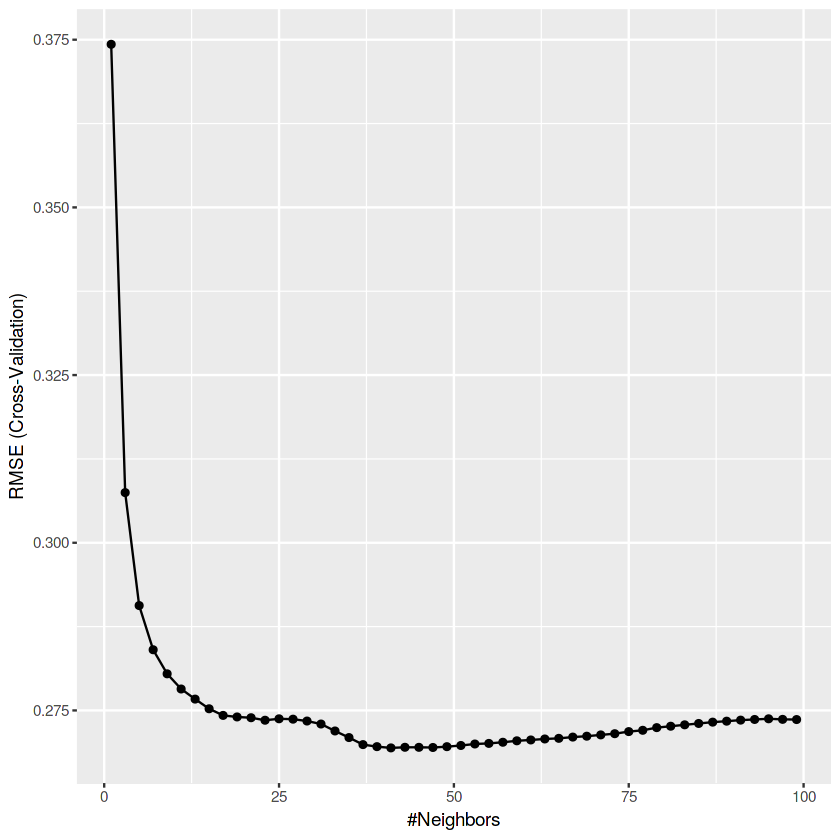

In [23]:
# Inspect cross validated RMSE for our range of k
ggplot(avo_knn)

In [24]:
# The k chosen by our trained KNN model
avo_knn$bestTune

,k
,<dbl>
21,41


In [25]:
# Make predictions on test set
knn_pred = predict(
    avo_knn,
    newdata = test_cs
)
# The results
knn_df = data.frame(
    id = test %>% select(id),
    average_price = avocado %>% filter(id %in% test_rows) %>% select(average_price),
    pred = knn_pred
)

In [26]:
# Inspect predictions
head(knn_df)

,id,average_price,pred
,<chr>,<dbl>,<dbl>
1,4,1.08,1.072683
2,12,1.28,1.097561
3,13,1.31,1.093171
4,15,1.33,1.110488
5,17,1.11,1.110732
6,27,1.37,1.131220


### Model 3: Random Forest

In [27]:
# Train a random forest model on the train set (no dummies, not centered/scaled)
avo_forest = train(
    # The model: predict average price based on everything else
    average_price ~ .,
    # The data: non-pre-processed train dataframe, without id
    data = train %>% select(-id),
    # Use ranger to implement random forest with 100 trees
    method = "ranger",
    num.trees = 100,
    # Evaluate performance with out-of-bag error estimation
    trControl = trainControl(method = "oob"),
    # Tuning parameters: mtry - number of random predictors at each split,
    # splitrule - the rule for splitting,
    # and min.node.size - minimum number of observations per leaf
    tuneGrid = expand.grid("mtry" = c(8, 10, 12, 14),
                          "splitrule" = "variance",
                          "min.node.size" = 1:10)
)

In [28]:
# The mtry and min.node.size selected by trained Random Forest model
avo_forest$bestTune

,mtry,splitrule,min.node.size
,<dbl>,<fct>,<int>
4,14,variance,1


In [29]:
# Make predictions on test set
forest_pred = predict(
    avo_forest,
    newdata = test
)

# The results
forest_df = data.frame(
    id = test %>% select(id),
    average_price = avocado %>% filter(id %in% test_rows) %>% select(average_price),
    pred = forest_pred
)

In [30]:
# Inspect predictions
head(forest_df)

,id,average_price,pred
,<chr>,<dbl>,<dbl>
1,4,1.08,1.164203
2,12,1.28,1.204922
3,13,1.31,1.209585
4,15,1.33,1.232987
5,17,1.11,1.094572
6,27,1.37,1.275876


### Model 4: Support Vector Machine (SVM)
We ran a regression SVM with a linear kernel. We also attempted radial and polynomial kernels, but these models took long enough to run that we never saw results - we always had to terminate our session before they finished. We include the code here, commented out and in hidden chunks, in case we want to revive them later.

In [31]:
# Train a regression SVM model
avo_svm = train(
    # The model: predict average price based on everything else
    average_price ~ .,
    # the data: dummied/centered/scaled training data, without id
    data = train_cs %>% select(-id),
    # Implement a linear kernel support vector machine for regression
    method = "svmLinear3",
    response = "regression",
    svr_eps = 0.1,
    # Evaluate performance using 5-fold cross validation
    trControl = trainControl(method = "cv", number = 5),
    # Tuning parameter: cost
    tuneGrid = expand.grid(cost = 10^seq(-2, 1, by = 1), Loss = "rmse")
)

In [32]:
# The cost chosen by our trained SVM model
avo_svm$bestTune

,cost,Loss
,<dbl>,<fct>
2,0.1,rmse


In [33]:
# Make predictions on test set
svm_pred = predict(
    avo_svm,
    newdata = test_cs
)

# The results
svm_df = data.frame(
    id = test %>% select(id),
    average_price = avocado %>% filter(id %in% test_rows) %>% select(average_price),
    pred = svm_pred
)

In [34]:
# Inspect results
head(svm_df)

,id,average_price,pred
,<chr>,<dbl>,<dbl>
1,4,1.08,1.108125
2,12,1.28,1.298175
3,13,1.31,1.297738
4,15,1.33,1.296629
5,17,1.11,1.295421
6,27,1.37,1.238885


In [35]:
# Radial 
# Train a radial SVM model
#avo_svm_rad = train(
    # The model: predict average price based on everything else
#   average_price ~ .,
#    # the data: dummied/centered/scaled training data, without id
#    data = train_cs %>% select(-id),
    # Implement a linear kernel support vector machine for regression
#    method = "svmRadial",
#    response = "regression",
#    svr_eps = 0.1,
#    tuneGrid = expand.grid(sigma = c(0.1, 1, 5, 10, 20), C = 10^seq(-2, 1, by = 1)),
    # Evaluate performance using 5-fold cross validation
#    trControl = trainControl(method = "cv", number = 5)
    # Use default values for tuning parameters
#)

# Make predictions on test set
#svm_pred_rad = predict(
#    avo_svm_rad,
#    newdata = test_cs
#)

# The results
#svm_df_rad = data.frame(
#    id = test %>% select(id),
#    average_price = avocado %>% filter(id %in% test_rows) %>% select(average_price),
#    pred = svm_pred_rad
#)

#head(svm_df_rad)

In [36]:
# Polynomial 
# Train a polynomial SVM model
#avo_svm_poly = train(
    # The model: predict average price based on everything else
#    average_price ~ .,
    # the data: dummied/centered/scaled training data, without id
#    data = train_cs %>% select(-id),
    # Implement a linear kernel support vector machine for regression
#    method = "svmPoly",
#    response = "regression",
#    svr_eps = 0.1,
#    tuneGrid = expand.grid(degree = 2:5, scale = 1, C = 10^seq(-2, 1, by = 1)),
    # Evaluate performance using 5-fold cross validation
#    trControl = trainControl(method = "cv", number = 5)
    # Use default values for tuning parameters
#)

# Make predictions on test set
#svm_pred_poly = predict(
#    avo_svm_rad,
#    newdata = test_cs
#)

# The results
#svm_df_poly = data.frame(
#    id = test %>% select(id),
#    average_price = avocado %>% filter(id %in% test_rows) %>% select(average_price),
#    pred = svm_pred_poly
#)

#head(svm_df_rad)

### Bonus: Stacked Regression

We can attempt to get better predictions by running a stacked regression of our previous models. To do this, we can use the `caretList` and `caretEnsemble` functions from the `caretEnsemble` package. `caretList` creates a list of caret models, and `caretEnsemble` takes this list and returns a stacked regression of its models. Since `caretList` requires that all models train on the same training set, we only include the elasticnet, KNN, and SVM models in this stacked regression. All three of these models trained on the dummy/centered/scaled version of the dataset, while the random forest trained on the no-dummy, non-centered, non-scaled version and is thus not included in this stacked regression.

In [68]:
# Create list of models to stack
avo_list = caretList(
    # All models predict average price based on everthing else
    average_price ~ .,
    # All models use dummy/centered/scaled training data, without id
    data = train_cs %>% select(-id),
    # List of caret models to stack, and their tuning parameters
    tuneList = list(net_model = caretModelSpec(method = "glmnet", tuneGrid = expand.grid(alpha = alphas, lambda = lambdas)),
                    knn_model = caretModelSpec(method = "knn", tuneGrid = expand.grid(k = seq(1, 100, by = 2))),
                    svm_model = caretModelSpec(method = "svmLinear3", svr_eps = 0.1, tuneGrid = expand.grid(cost = 10^seq(-2, 1, by = 1), Loss = "rmse"))
                    ),
    # Evaluate using 5-fold cross validation and save final predictions
    trControl = trainControl(method = "cv", number = 5, savePredictions = "final")
)

# Create stacked regression model
avo_stack = caretEnsemble(avo_list)

Warning message in trControlCheck(x = trControl, y = target):
“indexes not defined in trControl.  Attempting to set them ourselves, so each model in the ensemble will have the same resampling indexes.”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”
Warning message in LiblineaR::LiblineaR(data = as.matrix(x), target = y, cost = param$cost, :
“No value provided for svr_eps. Using default of 0.1”
Warning message in LiblineaR::LiblineaR(data = as.matrix(x), target = y, cost = param$cost, :
“No value provided for svr_eps. Using default of 0.1”
Warning message in LiblineaR::LiblineaR(data = as.matrix(x), target = y, cost = param$cost, :
“No value provided for svr_eps. Using default of 0.1”
Warning message in LiblineaR::LiblineaR(data = as.matrix(x), target = y, cost = param$cost, :
“No value provided for svr_eps. Using default of 0.1”
Warning message in LiblineaR::LiblineaR(data = as.matr

In [70]:
# Make predictions on test set
stack_pred = predict(
    avo_stack,
    newdata = test_cs
)

# The results
stack_df = data.frame(
    id = test %>% select(id),
    average_price = avocado %>% filter(id %in% test_rows) %>% select(average_price),
    pred = stack_pred
)

In [71]:
# Inspect results
head(stack_df)

,id,average_price,pred
,<chr>,<dbl>,<dbl>
1,4,1.08,1.179640
2,12,1.28,1.079901
3,13,1.31,1.079805
4,15,1.33,1.141959
5,17,1.11,1.141743
6,27,1.37,1.230174


# Evaluating our Predictions

Now, we evaluate our predictions by calculating the test RMSE for each model.

In [73]:
# Define a function that takes in our results dataframes and returns test RMSE
rmse = function(df){
    (df$average_price - df$pred)^2 %>% mean() %>% sqrt()
}

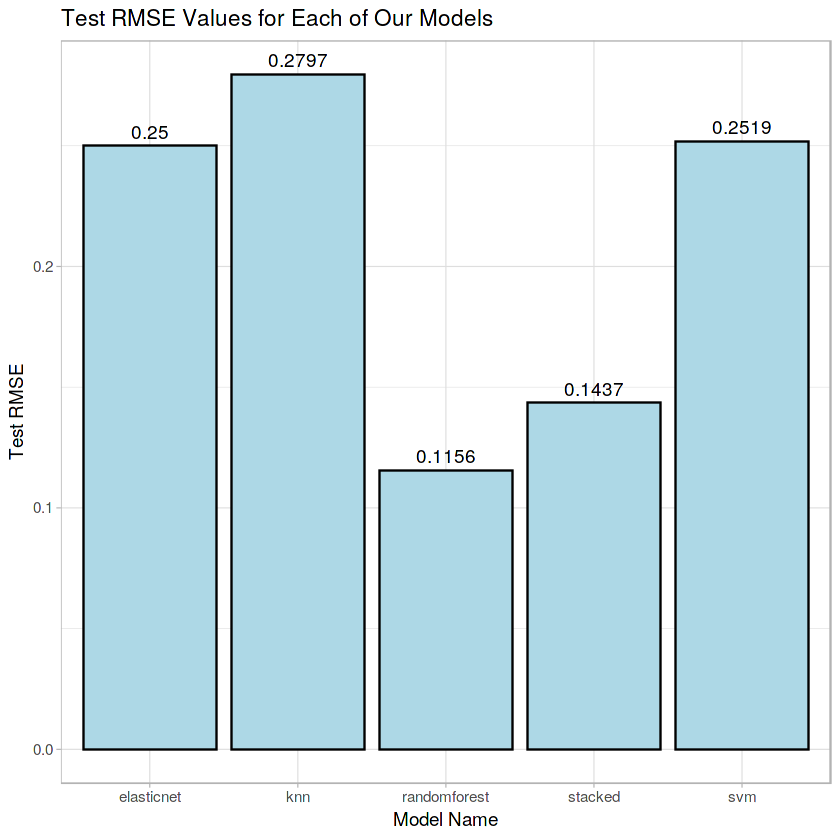

In [79]:
# Find the RMSE for each model
all_data <- data.frame(model_name = c("elasticnet", "knn", "randomforest", "svm", "stacked"),
                       rmse_vals = c(rmse(net_df), rmse(knn_df), rmse(forest_df), rmse(svm_df), rmse(stack_df)))

ggplot(all_data, aes(model_name, rmse_vals)) +
    geom_col(fill = c("lightblue"), col = "black") +
    geom_text(aes(label = round(rmse_vals, 4)), vjust = -0.5) +
    ggtitle("Test RMSE Values for Our Models") +
    xlab("Model Name") +
    ylab("Test RMSE") +
    theme_light()

As we can see from the figure, our worst performing model was the KNN model, second-worse was SVM, and third-worst was elasticnet. Our best model by far was the random forest. Amazingly, a stacked regression of our KNN, SVM, and elasticnet models is only slightly worse than the random forest, though it was made from three models performing significantly worse than the random forest.